# LSST CCOB ghost full fit to the geometry with iminuit

Show a Minuit implementation of fitting geometry to a set of ghosts catalogs

*Still very much in development*

## TODO
- understand uncertainties on parameters and compare to needed values
- move code to module
- fit multiple ghosts catalogs at a time 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize_scalar, minimize

import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import reduce_ghosts, compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1
from ghosts.geom_configs import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 9000 pixels per mm^2


### True ghosts catalog ~ real data
- Build an aligned telescope, choose one CCOB ghost config, generate ghosts catalog

In [4]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

# CCOB like geometry, i.e. lenses but no filter
ref_telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(ref_telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

0

In [5]:
# Cool ghost configuration
ref_beam = copy.deepcopy(BEAM_CONFIG_0)
ref_beam['beam_id'] = 999042
ref_beam['n_photons'] = 10000
ref_beam['x_offset'] = +0.3
ref_beam['y_offset'] = -0.55
ref_beam['x_euler'] = -17
ref_beam['y_euler'] = -6

# make a copy with less photons for the fit
fit_beam = copy.deepcopy(ref_beam)
fit_beam['n_photons'] = 1000

In [6]:
# Ray trace one config for debugging
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(ref_telescope, beam_config=ref_beam)
simulation = [trace_full, r_forward, r_reverse, rays]

# reduce ghosts
ref_spots_data, _spots = reduce_ghosts(r_forward)
ref_spots_data_frame = make_data_frame(ref_spots_data, beam_id=ref_beam['beam_id'], geom_id=0)
ref_gh_sep = compute_ghost_separations(ref_spots_data_frame)
ref_spots_data_frame.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,n_pixels,pixel_signal
12,999042,0,12,"(Detector, L2_entrance)",-0.016795,0.000494,0.312473,0.000494,0.001973,0.001944,0.000979,0.000015,4.626507,3.013125,27118,4.380130e+03
13,999042,0,13,"(Detector, L2_exit)",-0.043923,0.000161,0.218483,0.000161,0.000643,0.000539,0.000296,0.000052,4.663742,0.274503,2471,4.846615e+04
14,999042,0,14,"(Detector, L3_entrance)",0.104796,0.000566,-0.010248,0.000566,0.002263,0.002251,0.001129,0.000006,4.701277,4.001395,36013,3.351624e+03
15,999042,0,15,"(Detector, L3_exit)",0.122999,0.000620,-0.033619,0.000620,0.002479,0.002487,0.001241,0.000004,4.739115,4.841426,43573,2.792382e+03
0,999042,0,0,"(L1_exit, L1_entrance)",-0.027527,0.000243,0.211848,0.000243,0.000972,0.000754,0.000432,0.000109,0.134121,0.585402,5269,6.535746e+02
3,999042,0,3,"(L2_entrance, L1_exit)",-0.046040,0.000345,0.315320,0.000345,0.001378,0.001297,0.000669,0.000041,0.134121,1.405337,12648,2.722505e+02
1,999042,0,1,"(L2_exit, L1_entrance)",0.139654,0.000882,0.055470,0.000882,0.003524,0.003509,0.001758,0.000008,0.131988,9.712920,87416,3.876473e+01
2,999042,0,2,"(L2_exit, L1_exit)",0.257853,0.001354,-0.041904,0.001354,0.005411,0.005376,0.002697,0.000017,0.133051,22.847648,205629,1.661217e+01
4,999042,0,4,"(L2_exit, L2_entrance)",0.245676,0.001053,-0.172815,0.001053,0.004207,0.004079,0.002072,0.000064,0.134121,13.481094,121330,2.838076e+01
7,999042,0,7,"(L3_entrance, L1_entrance)",0.074592,0.000938,0.274407,0.000938,0.003750,0.003764,0.001879,0.000007,0.130935,11.086172,99776,3.369175e+01


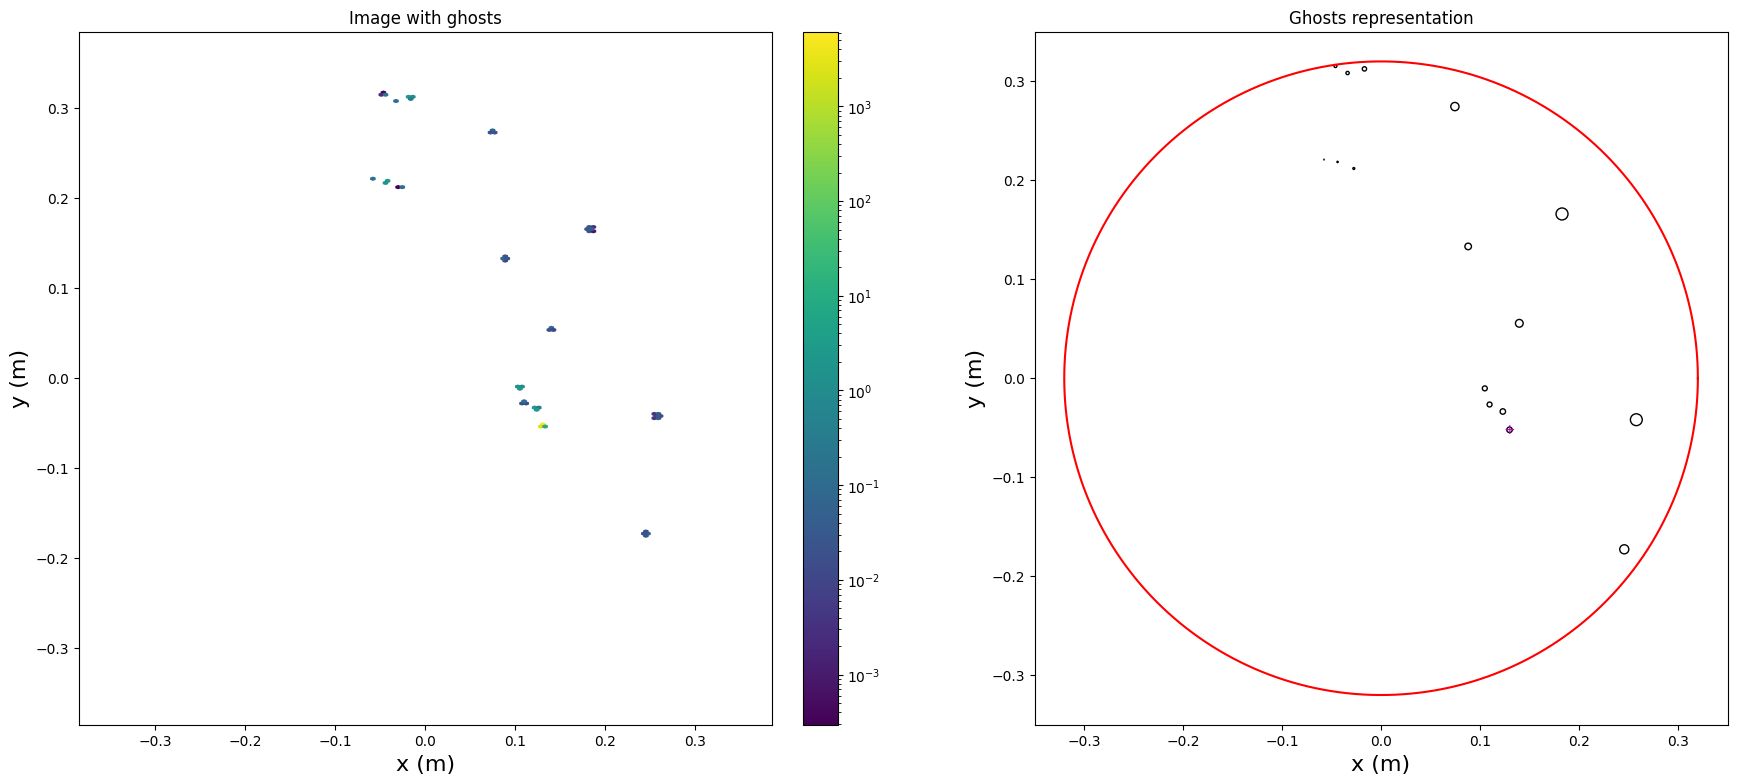

In [7]:
# plot focal plane
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, ref_spots_data_frame, log_scale=True)

### Function to save plots of the ghosts map

In [8]:
import time

def save_spot_fig(spots_data_frame):
    spots_fig, _ax = plotter.plot_spots([spots_data_frame])
    _ax.set_aspect("equal")
    # Plot approximate focal plane radius
    th = np.linspace(0, 2 * np.pi, 1000)
    plt.plot(0.32 * np.cos(th), 0.32 * np.sin(th), c='r')
    spots_fig.savefig(f"reference_spots_{time.time()}.png", dpi=100)
    plt.close()

save_spot_fig(ref_spots_data_frame)

### Full fit using Minuit

In [9]:
GEOM_LABELS = ["L1_dx", "L1_dy", "L1_dz", "L1_rx", "L1_ry",
               "L2_dx", "L2_dy", "L2_dz", "L2_rx", "L2_ry",
               "L3_dx", "L3_dy", "L3_dz", "L3_rx", "L3_ry"]


def unpack_geom_params(geom_params, geom_labels=GEOM_LABELS):
    fitted_geom_config = {}
    for i, lab in enumerate(geom_labels):
        fitted_geom_config[lab]=geom_params[i]
    return fitted_geom_config


def build_telescope_to_fit(geom_params):
    """ Build telescope to fit from reference telescope
    """
    # Build telescope
    fitted_geom_config = unpack_geom_params(geom_params)
    fitted_telescope = tweak_optics.tweak_telescope(ref_telescope, fitted_geom_config)
    # Make refractive interfaces partially reflective
    tweak_optics.make_optics_reflective(fitted_telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])
    return fitted_telescope


def compute_distance_for_fit(geom_params_array):
    """ Callable function for the fit
    """
    geom_params=geom_params_array.tolist()
    # new telescope
    fitted_telescope = build_telescope_to_fit(geom_params)
    fit_spots_df = simulator.run_and_analyze_simulation(fitted_telescope, geom_id=0, beam_config=fit_beam)
    # save spots figure
    #save_spot_fig(fit_spots_df)
    # match ghosts
    match = match_ghosts(ref_spots_data_frame, fit_spots_df, radius_scale_factor=10)
    dist_2d = compute_2d_reduced_distance(match)
    fitted_geom_config = unpack_geom_params(geom_params)
    # Minuit can actually take a callback function
    if not np.random.randint(10)%9:
        print(f'{dist_2d:.6f} {fitted_geom_config["L1_dx"]:.6f} {fitted_geom_config["L1_dy"]:.6f} {fitted_geom_config["L1_dz"]:.6f} {fitted_geom_config["L1_rx"]:.6f} {fitted_geom_config["L1_ry"]:.6f}', end=" ")
        print(f'{dist_2d:.6f} {fitted_geom_config["L2_dx"]:.6f} {fitted_geom_config["L2_dy"]:.6f} {fitted_geom_config["L2_dz"]:.6f} {fitted_geom_config["L2_rx"]:.6f} {fitted_geom_config["L2_ry"]:.6f}', end=" ")
        print(f'{dist_2d:.6f} {fitted_geom_config["L3_dx"]:.6f} {fitted_geom_config["L3_dy"]:.6f} {fitted_geom_config["L3_dz"]:.6f} {fitted_geom_config["L3_rx"]:.6f} {fitted_geom_config["L3_ry"]:.6f}')
    # clean up
    del fitted_telescope
    return dist_2d



In [10]:
# init
geom_params_init=np.array([0.0]*15)

# bounds
dxs = [(-0.0005, 0.0005)]*3
rxs = [(-0.01, 0.01)]*2
list_of_bounds = (dxs+rxs)+(dxs+rxs)+(dxs+rxs)

# Minuit
from iminuit import Minuit

m = Minuit(compute_distance_for_fit, geom_params_init, name=tuple(GEOM_LABELS))
m.limits = list_of_bounds
m.precision = 1e-6
print(m.params)

m.migrad(ncall=50, iterate=5)  # run optimiser
m.hesse()   # run covariance estimator

print(m.values)
print(m.errors)


┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ L1_dx │    0.0    │    0.1    │            │            │ -0.0005 │ 0.0005  │       │
│ 1 │ L1_dy │    0.0    │    0.1    │            │            │ -0.0005 │ 0.0005  │       │
│ 2 │ L1_dz │    0.0    │    0.1    │            │            │ -0.0005 │ 0.0005  │       │
│ 3 │ L1_rx │    0.0    │    0.1    │            │            │  -0.01  │  0.01   │       │
│ 4 │ L1_ry │    0.0    │    0.1    │            │            │  -0.01  │  0.01   │       │
│ 5 │ L2_dx │    0.0    │    0.1    │            │            │ -0.0005 │ 0.0005  │       │
│ 6 │ L2_dy │    0.0    │    0.1    │            │            │ -0.0005 │ 0.0005  │       │
│ 7 │ L2_dz │    0.0    │    0.1    │            │            │ -0.0005 │ 0.0005

/pbs/home/b/bregeon/lsst/conda/envs/ghosts/lib/python3.8/site-packages/iminuit/minuit.py:2345: IMinuitWarning: Specified nsigma bound, but error matrix is not accurate
  warnings.warn(


0.000097 0.000000 0.000000 0.000000 -0.020435 0.000000 0.000097 0.000000 0.000000 0.000000 0.000000 0.000000 0.000097 0.000000 0.000000 0.000000 0.000000 0.000000
0.000091 0.000000 0.000000 0.000000 -0.019575 0.000000 0.000091 0.000000 0.000000 0.000000 0.000000 0.000000 0.000091 0.000000 0.000000 0.000000 0.000000 0.000000
0.000075 0.000000 0.000000 0.000000 -0.017424 0.000000 0.000075 0.000000 0.000000 0.000000 0.000000 0.000000 0.000075 0.000000 0.000000 0.000000 0.000000 0.000000
0.000072 0.000000 0.000000 0.000000 -0.015273 0.000000 0.000072 0.000000 0.000000 0.000000 0.000000 0.000000 0.000072 0.000000 0.000000 0.000000 0.000000 0.000000
0.000057 0.000000 0.000000 0.000000 -0.012691 0.000000 0.000057 0.000000 0.000000 0.000000 0.000000 0.000000 0.000057 0.000000 0.000000 0.000000 0.000000 0.000000
0.000050 0.000000 0.000000 0.000000 -0.010971 0.000000 0.000050 0.000000 0.000000 0.000000 0.000000 0.000000 0.000050 0.000000 0.000000 0.000000 0.000000 0.000000
0.000044 0.000000 0.00

(array([-0.02129569, -0.02086547, -0.02043526, -0.02000504, -0.01957482,
        -0.01914461, -0.01871439, -0.01828418, -0.01785396, -0.01742374,
        -0.01699353, -0.01656331, -0.0161331 , -0.01570288, -0.01527267,
        -0.01484245, -0.01441223, -0.01398202, -0.0135518 , -0.01312159,
        -0.01269137, -0.01226115, -0.01183094, -0.01140072, -0.01097051,
        -0.01054029, -0.01011007, -0.00967986, -0.00924964, -0.00881943,
        -0.00838921, -0.00795899, -0.00752878, -0.00709856, -0.00666835,
        -0.00623813, -0.00580791, -0.0053777 , -0.00494748, -0.00451727,
        -0.00408705, -0.00365684, -0.00322662, -0.0027964 , -0.00236619,
        -0.00193597, -0.00150576, -0.00107554, -0.00064532, -0.00021511,
         0.00021511,  0.00064532,  0.00107554,  0.00150576,  0.00193597,
         0.00236619,  0.0027964 ,  0.00322662,  0.00365684,  0.00408705,
         0.00451727,  0.00494748,  0.0053777 ,  0.00580791,  0.00623813,
         0.00666835,  0.00709856,  0.00752878,  0.0

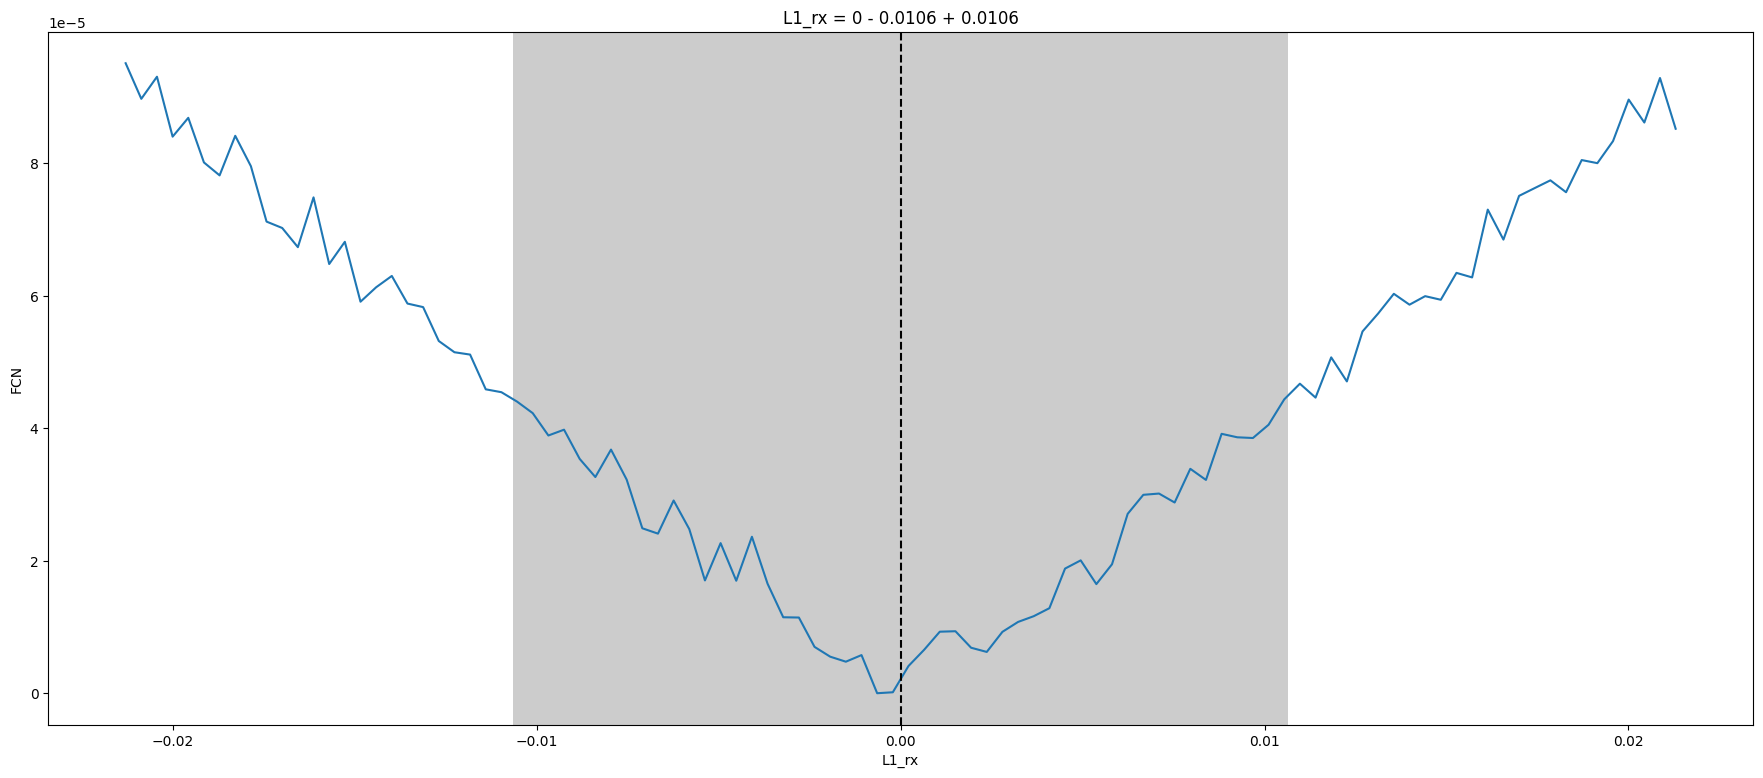

In [11]:
m.draw_profile("L1_rx")